+─────────────────────────────────────────────────────────────────+
|  Modelo de Estimación de Volatilidad basado en RF               |
|  Ticker: GGAL.BA                                                |
+─────────────────────────────────────────────────────────────────+
|  Terciles (histórico):                                          |
|    - p33 = 41.69%                                               |
|    - p66 = 52.64%                                               |
|    - p100 = 100.77%                                             |
+─────────────────────────────────────────────────────────────────+
|  Últimos 6 meses observados:                                    |
|  Mes        Vol_Anual_%   Categoria                             |
|  2025-03          51.65     Media                               |
|  2025-04          83.74     Alta                                |
|  2025-05          38.33     Baja                                |
|  2025-06          43.02     Media             

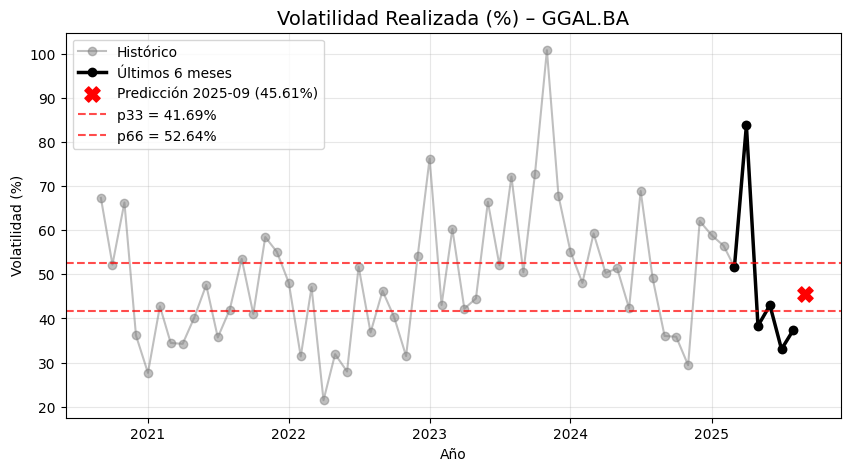

In [37]:
# =======================
# Estimador de volatilidad RF
# =======================
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from math import erf, sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# ------------------------
# 0. Parámetros
# ------------------------
ticker = "GGAL.BA"                     # define el activo a descargar
years_back = 5                         # cantidad de años de historia que se quiere descargar
trading_days = 252                     # año bursátil (para anualizar volatilidad).
cutoff_date = None                     # None = último mes completo

# ------------------------
# 1. Descarga
# ------------------------
today = datetime.today()                                                                  # fecha actual
start = today - timedelta(days=int(years_back*365.25))                                    # fecha de inicio (hoy - 5 años) .25 para ser prolijo con años bisiestos
price = yf.download(ticker, start=start, end=today, auto_adjust=True, progress=False)
if price.empty:                                                                           # si price vino vacío (ej. ticker mal escrito o sin datos), corta la ejecución con un error
    raise ValueError("Sin datos del ticker.")

df = price[['Close']].copy()
df['Ret (%)'] = df['Close'].pct_change()
df = df.dropna()                                                                          # elimina las filas sin data (primera fila)

# ------------------------
# 2. Recorte a meses completos
# ------------------------
if cutoff_date is not None:                                                        # si el usuario definió manualmente un cutoff_date (ej. "2025-07-31"), usamos eso como fecha de corte.
    last_full_month_end = pd.to_datetime(cutoff_date)
else:
    last_date = df.index.max()                                                     # si no hay cutoff_date, tomamos la última fecha disponible en los datos (last_date).
    month_end = last_date.to_period("M").to_timestamp("M")                         # convertimos esa fecha al fin del mes calendario.
    if last_date < month_end:                                                      # si el ultimo dato se dio antes de completar el mes (mes incompleto)
        last_full_month_end = (last_date.to_period("M") - 1).to_timestamp("M")     # vamos al ultimo dato y vemos en que mes se encuentra y vamos 1 mes atras y usamos el fin del mes anterior
    else:
        last_full_month_end = month_end                                            # si el ultimo dato es el ultimo dia del mes lo usamos

df = df.loc[df.index <= last_full_month_end]                                       # el df solo tendra meses completos
next_month = last_full_month_end.to_period("M") + 1                                # mes a estimar

# ------------------------
# 3. Vol mensual anualizada
# ------------------------
df["Mes"] = df.index.to_period("M")                                                               # convierte las fechas (df.index) en períodos mensuales.
vol_mensual = (df.groupby("Mes")["Ret (%)"].std().to_frame("std_diaria"))                         # calculo std diaria
vol_mensual["Vol_Anual_%"] = vol_mensual["std_diaria"] * np.sqrt(trading_days) * 100              # anualizamos
vol_mensual = vol_mensual.dropna().reset_index()

# ------------------------
# 4. Terciles históricos
# ------------------------
hist = vol_mensual.copy().sort_values("Mes").reset_index(drop=True)
p33 = round(hist["Vol_Anual_%"].quantile(1/3), 2)                                    # percentil 33%
p66 = round(hist["Vol_Anual_%"].quantile(2/3), 2)                                    # percentil 66%
p100 = round(hist["Vol_Anual_%"].quantile(1), 2)                                     # percentil 100%

def categoria_por_valor(v):                                                          # funcion que aplica categoria segun terciles
    if v < p33: return "Baja"
    elif v < p66: return "Media"
    else: return "Alta"

hist["Categoria"] = hist["Vol_Anual_%"].apply(categoria_por_valor)                   # aplicamos la funcion a la columna "Vol_Anual_%"

# ------------------------
# 5. Random Forest (IA) sobre vol en nivel con features de lags/medias
# ------------------------
Z = hist[["Mes","Vol_Anual_%"]].copy()                                 # nos quedamos con el mes y la vol (target)

# lags 1..6
for k in [1,2,3,4,5,6]:                                                # vamos a crear 6 columnas que nos indique el valor de los lags (std pasados)
    Z[f"lag{k}"] = Z["Vol_Anual_%"].shift(k)

# medias móviles SOLO con pasado (evita leakage)
Z["ma3"] = Z["Vol_Anual_%"].shift(1).rolling(3).mean()                 # media movil de 3 periodos
Z["ma6"] = Z["Vol_Anual_%"].shift(1).rolling(6).mean()                 # media movil de 6 periodos

Z = Z.dropna().reset_index(drop=True)                                  # eliminamos las filas sin datos

features = [c for c in Z.columns if c not in ["Mes","Vol_Anual_%"]]    # recorre las columnas que no son "Mes" y "Vol_Anual_%""
X_rf = Z[features].values                                              # df de variables explicativas ["lag1", "lag2", "lag3", "ma3", "ma6"] (.value lo convierte en una matriz)
y_rf = Z["Vol_Anual_%"].values                                         # df de columna objetivo (.value lo convierte en una matriz)

# Dividir en train/test
train_size = int(len(Z) * 0.8)
X_train, X_test = X_rf[:train_size], X_rf[train_size:]
y_train, y_test = y_rf[:train_size], y_rf[train_size:]

# Entrenar modelo
rf = RandomForestRegressor(
    n_estimators=500,             # n de arboles de decision
    max_depth=None,               # profundidad de cada arbol, no tiene limite
    min_samples_leaf=3,           # cada hoja debe tener al menos 3 obs
    random_state=35,              # fija la semilla aleatoria
    n_jobs=-1                     # define cuantos procesadores usar, -1 significa que usara todos los nucleos del CPU en paralelo
)
rf.fit(X_train, y_train)                # entrenamiento, usamos los parametros de rf para el fit (entrenamiento) que lo aplicamos sobre las matrices

# Validación del modelo
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# ----- Estimacion t+1 -----
vals = hist["Vol_Anual_%"].values                                  # matriz de std historica
if len(vals) < 6:                                                  # condicion min 6 meses
    raise ValueError("Faltan meses para armar lags (mínimo 6).")

x_next_df = pd.DataFrame([[                                        # fila con inputs para estimar t+1
    vals[-1], vals[-2], vals[-3], vals[-4], vals[-5], vals[-6],    # ultimos 6 meses, ma3 y ma6
    np.mean(vals[-3:]), np.mean(vals[-6:])
]], columns=[f"lag{k}" for k in [1,2,3,4,5,6]] + ["ma3","ma6"])    # las columnas se ordenan para que coincidan con las de features

vol_pred_rf = float(rf.predict(x_next_df[features].values)[0])     # alimenta al modelo con estos inputs y devuelve una estimacion para t+1

# ---------------------------
# 6. Salida
# ---------------------------



print("+─────────────────────────────────────────────────────────────────+")
print("|  Modelo de Estimación de Volatilidad basado en RF               |")
print(f"|  Ticker: {ticker}                                                |")
print("+─────────────────────────────────────────────────────────────────+")
print(f"|  Terciles (histórico):                                          |")
print(f"|    - p33 = {p33:.2f}%                                               |")
print(f"|    - p66 = {p66:.2f}%                                               |")
print(f"|    - p100 = {p100:.2f}%                                             |")
print("+─────────────────────────────────────────────────────────────────+")
print("|  Últimos 6 meses observados:                                    |")
ultimos6 = hist[["Mes","Vol_Anual_%","Categoria"]].tail(6)
print("|  Mes        Vol_Anual_%   Categoria                             |")
for _, row in ultimos6.iterrows():
    mes = str(row['Mes'])
    vol = f"{row['Vol_Anual_%']:.2f}"
    cat = row['Categoria']
    print(f"|  {mes:<10} {vol:>11}     {cat:<12}                        |")
print("+─────────────────────────────────────────────────────────────────+")
print(f"|  Volatilidad esperada para {next_month} : {vol_pred_rf:.2f}% ({categoria_por_valor(vol_pred_rf)})             |")
print(f"|  MAE del modelo: {mae:.2f}%                                         |")
print("+─────────────────────────────────────────────────────────────────+")
print("")


# ------------------------
# 8. Gráfico de últimos 6 meses + predicción
# ------------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

# Serie completa
ax.plot(hist["Mes"].dt.to_timestamp(), hist["Vol_Anual_%"],
        marker="o", linestyle="-", color="gray", alpha=0.5, label="Histórico")

# Últimos 6 meses
ultimos6 = hist.tail(6)
ax.plot(ultimos6["Mes"].dt.to_timestamp(), ultimos6["Vol_Anual_%"],
        marker="o", linestyle="-", color="black", linewidth=2.5, label="Últimos 6 meses")

# Predicción t+1
ax.scatter([next_month.to_timestamp()], [vol_pred_rf],
           color="red", s=120, marker="X", label=f"Predicción {next_month} ({vol_pred_rf:.2f}%)")

# Líneas de referencia de terciles
ax.axhline(p33, color="red", linestyle="--", alpha=0.7, label=f"p33 = {p33:.2f}%")
ax.axhline(p66, color="red", linestyle="--", alpha=0.7, label=f"p66 = {p66:.2f}%")

# Formato
ax.set_title(f"Volatilidad Realizada (%) – {ticker}", fontsize=14)
ax.set_xlabel("Año")
ax.set_ylabel("Volatilidad (%)")
ax.legend()
ax.grid(alpha=0.3)

plt.show()

